In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy, spearmanr
import seaborn as sns
from sklearn.metrics import r2_score
from pydub import AudioSegment
from sklearn.decomposition import FastICA

import warnings
warnings.filterwarnings('ignore')

In [2]:
rate1 = AudioSegment.from_file("audio_data/sample-0.mp3", format="mp3")

In [3]:
rate1.duration_seconds

10.0469375

In [4]:
rate1.channels

1

In [5]:
rate1.frame_rate

16000

In [6]:
rates = {}
ampli = {}
time = {} 
for i in range(9):  # From 0 to 9
    file_name = f"audio_data/sample-{i}.mp3"  # Generate file name
    rates[f"rate{i}"] = AudioSegment.from_file(file_name, format="mp3")
    ampli[f"rate{i}"] = np.array(rates[f"rate{i}"].get_array_of_samples())
    time[f"rate{i}"] = np.linspace(0, len(ampli[f"rate{i}"]) / 1000, num=len(ampli[f"rate{i}"]))

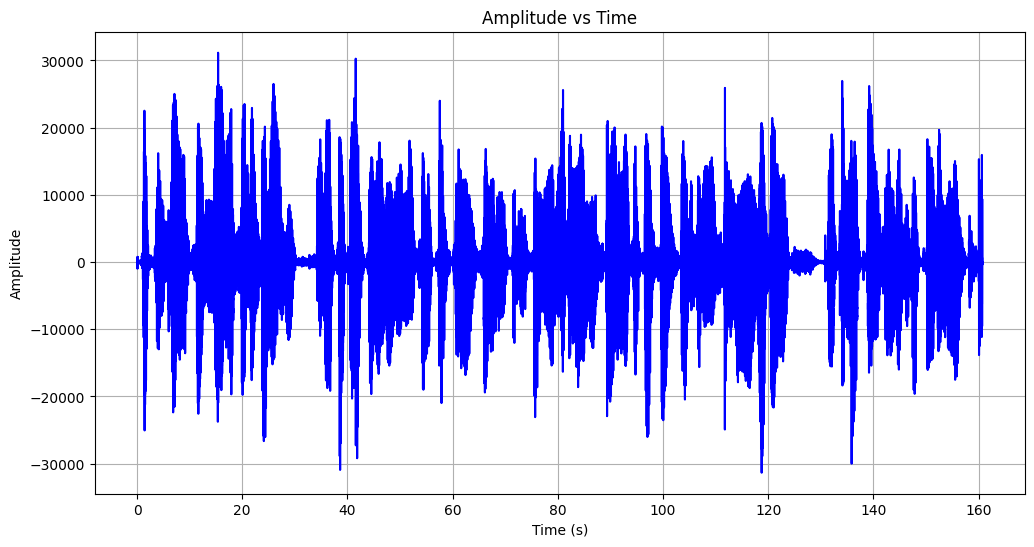

In [7]:
time1 = time['rate0']
plt.figure(figsize=(12, 6))
plt.plot(time1, ampli['rate0'], color="blue")
plt.title("Amplitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [8]:
min_time = time['rate0'].shape

for i in range(9):
    print(time[f'rate{i}'].shape)
    min_time = min(min_time, time[f'rate{i}'].shape)
min_time = min_time[0]
print("The minimum time is: ", min_time)

(160751,)
(160751,)
(160751,)
(160684,)
(160751,)
(160751,)
(160684,)
(160751,)
(160751,)
The minimum time is:  160684


In [9]:
for i in range(9):
    ampli[f'rate{i}'] = ampli[f'rate{i}'][:5000]

In [10]:
all_audios = []
for i in range(9):
    all_audios.append(ampli[f'rate{i}'])
all_audios

[array([  -2,    4,    8, ..., 4512, 4248, 3991], dtype=int16),
 array([    2,     0,   -12, ..., -1012, -2080, -3305], dtype=int16),
 array([    -1,     -2,      2, ..., -20434, -21994, -21342], dtype=int16),
 array([ -2,   0,   2, ..., 939, 941, 878], dtype=int16),
 array([   6,   -6,    8, ..., -355,  240, -696], dtype=int16),
 array([  0,   2,   4, ..., 950, 512, 285], dtype=int16),
 array([    4,     1,     0, ..., -1599,   577,  1136], dtype=int16),
 array([   -1,    -2,   -10, ...,  5545,  -417, -4358], dtype=int16),
 array([ -11,  -12,   -6, ..., 2600, 3633, 4432], dtype=int16)]

In [11]:
ampli['rate0']

array([  -2,    4,    8, ..., 4512, 4248, 3991], dtype=int16)

In [12]:
S = np.vstack(all_audios)
S.shape

(9, 5000)

In [13]:
A = np.random.uniform(-1, 1, size=(20, 9))
X = A@S
X.shape

(20, 5000)

## CW_ICA methodology

In [14]:
max_ICs = 15
B1 = X[:2, :]
B2 = X[2:, :]
B2.shape

(18, 5000)

In [15]:
IC_stored = {}

for i in range(2, max_ICs):
    ica = FastICA(n_components=i, random_state=42)
    S_ = ica.fit_transform(np.transpose(B1))
    # print(f"For i = {i}, the ICs are: ", S_)
    IC_stored[i-2] = S_

In [16]:
IC_stored_2 = {}

for i in range(2, max_ICs):
    ica = FastICA(n_components=i, random_state=42)
    S_ = ica.fit_transform(np.transpose(B2))
    # print(f"For i = {i}, the ICs are: ", S_)
    IC_stored_2[i-2] = S_

In [17]:
def cw_ica(X, A_max, rep):
    samples, _ = X.shape
    qopt_vals = []
    
    for _ in range(rep):
        q = 2
        idx = np.random.permutation(samples)
        B1, B2 = X[idx[:samples//2]], X[idx[samples//2:]]
        print("Size of B's are", B1.shape)
        D = {}
        
        prev_R_iq = None
        while q <= A_max:
            # Perform ICA with q components
            ica1, ica2 = FastICA(n_components=q, random_state=42), FastICA(n_components=q, random_state=42)
            S1, S2 = ica1.fit_transform(B1), ica2.fit_transform(B2)
            
            P = np.abs(spearmanr(S1, S2, axis=0)[0])
            # print("The shape of P is: ", P.shape, "\n")
            P = P[:q, q:]
            # print("Value of q is: ", q, "\nShape of S1", S1.shape, "\nShape of P ", P.shape, " ")
            
            # if P.size == 0:
            #     continue  # Prevents zero-size array error
            
            R_iq = np.min(np.max(P, axis=0))
            
            if prev_R_iq is not None:
                D[q] = R_iq - prev_R_iq
            
            prev_R_iq = R_iq
            q += 1
        
        if D:
            qopt_vals.append(min(D, key=D.get) - 1)
        k = []
        val = []
    
        for key, value in D.items():
            k.append(key)
            val.append(value)
        plt.plot(k, val)
    return qopt_vals, D # if qopt_vals else 2  # Default fallback


Size of B's are (10, 5000)
Size of B's are (10, 5000)
Size of B's are (10, 5000)
Size of B's are (10, 5000)
Size of B's are (10, 5000)
Estimated number of independent components: [4, 3, 2, 6, 4]


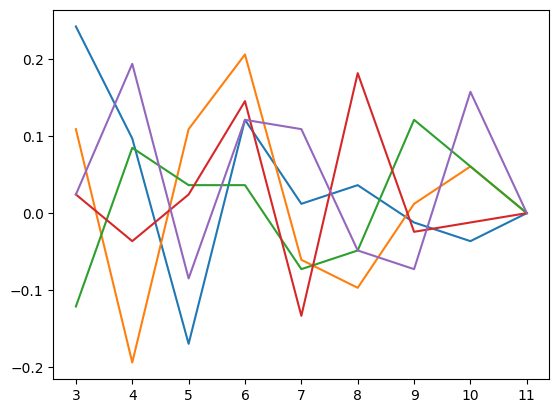

In [18]:
# Step 3: Determine the number of ICs
A_max = 11  # Max possible ICs
rep = 5  # Number of repetitions
optimal_ics, D = cw_ica(X, A_max, rep)

print(f"Estimated number of independent components: {optimal_ics}")